Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from skimage import graph as skgraph
from skimage.measure import regionprops
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

In [3]:
# Preprocessing parameters
IMAGE_SIZE = (264, 264)
SLIC_PARAMS = {'n_segments': 25, 'compactness': 10, 'sigma': 1.0}
slic_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
DATASET_PATH = "D:\\Academics\\ML_Proj\\Dataset"

Data Preprocessing

In [5]:
def create_graph(img_path, label=None):
    try:
        print(f"Opening image: {img_path}")
        if not os.path.exists(img_path):
            raise FileNotFoundError("Image file does not exist")
        
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            print(f"Image mode: {img.mode}, size: {img.size}")
            img_tensor = slic_transform(img)
            if img_tensor is None:
                raise ValueError("Transform returned None")
            print(f"Tensor shape: {img_tensor.shape}")
            img_np = img_tensor.permute(1, 2, 0).numpy()
            if img_np is None or img_np.size == 0:
                raise ValueError("NumPy array is None or empty")
            print(f"NumPy array shape: {img_np.shape}, dtype: {img_np.dtype}")
            
            segments = slic(img_np, **SLIC_PARAMS)
            print(f"Segments shape: {segments.shape}, unique values: {np.unique(segments)}")
            unique_seg_ids = np.unique(segments)
            
            props = regionprops(segments + 1)
            prop_dict = {p.label - 1: p for p in props}
            print(f"Number of regions: {len(props)}")
            
            node_features = []
            valid_seg_ids = []
            for seg_id in unique_seg_ids:
                mask = segments == seg_id
                if np.any(mask):
                    mean_color = img_np[mask].mean(axis=0)
                    y, x = np.where(mask)
                    if seg_id in prop_dict:
                        prop = prop_dict[seg_id]
                        node_features.append(np.concatenate([
                            mean_color,
                            [x.mean() / IMAGE_SIZE[1], y.mean() / IMAGE_SIZE[0]],
                            [prop.area / (IMAGE_SIZE[0] * IMAGE_SIZE[1])],
                            [prop.eccentricity]
                        ]))
                        valid_seg_ids.append(seg_id)
                    else:
                        print(f"Skipping seg_id {seg_id} in {img_path}: not in regionprops")
            
            if not node_features:
                print(f"No valid superpixels for {img_path}")
                return None
            
            node_features = np.array(node_features)
            node_features = (node_features - node_features.mean(axis=0)) / (node_features.std(axis=0) + 1e-8)
            num_nodes = len(node_features)
            print(f"Node features shape: {node_features.shape}")
            
            rag = skgraph.rag_mean_color(img_np, segments)
            edges = []
            seg_id_to_idx = {seg_id: idx for idx, seg_id in enumerate(valid_seg_ids)}
            for edge in rag.edges():
                u, v = edge[0], edge[1]
                if u in seg_id_to_idx and v in seg_id_to_idx:
                    edges.append([seg_id_to_idx[u], seg_id_to_idx[v]])
                    edges.append([seg_id_to_idx[v], seg_id_to_idx[u]])
            
            if not edges and num_nodes > 1:
                edges = [[0, 1], [1, 0]]
            
            edges = np.array(edges)
            print(f"Edges shape: {edges.shape}")
            
            if edges.size > 0 and (edges.max() >= num_nodes or edges.min() < 0):
                print(f"Invalid edges for {img_path}: {edges}, num_nodes={num_nodes}")
                return None
            
            if label is not None:
                graph = Data(
                    x=torch.from_numpy(node_features).float(),
                    edge_index=torch.from_numpy(edges).t().contiguous().long(),
                    y=torch.tensor([label], dtype=torch.float),
                    img_path=img_path
                )
            else:
                graph = Data(
                    x=torch.from_numpy(node_features).float(),
                    edge_index=torch.from_numpy(edges).t().contiguous().long(),
                    img_path=img_path
                )
            print(f"Graph created for {img_path}: {graph}")
            return graph
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

Data Loading

In [7]:
def load_dataset(dataset_path, split, max_samples_per_class=None):
    data_list = []
    categories = {'DFU': 0, 'Non DFU': 1}
    class_counts = {'DFU': 0, 'Non DFU': 0}
    
    for category, label in categories.items():
        folder_path = os.path.join(dataset_path, split, category)
        if not os.path.exists(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
        
        print(f"Processing {split}/{category}...")
        image_files = os.listdir(folder_path)[:max_samples_per_class]
        for img_file in image_files:
            img_path = os.path.join(folder_path, img_file)
            graph = create_graph(img_path, label)
            if graph:
                data_list.append(graph)
                class_counts[category] += 1
    
    # Balance Non DFU by augmentation if needed
    target_non_dfu = class_counts['DFU']  # Match DFU count
    current_non_dfu = class_counts['Non DFU']
    if current_non_dfu < target_non_dfu:
        non_dfu_files = os.listdir(os.path.join(dataset_path, split, 'Non DFU'))
        for img_file in non_dfu_files[:target_non_dfu - current_non_dfu]:
            img_path = os.path.join(dataset_path, split, 'Non DFU', img_file)
            graph = create_graph(img_path, label=1)
            if graph:
                data_list.append(graph)
                class_counts['Non DFU'] += 1
    
    print(f"{split} class distribution: DFU={class_counts['DFU']}, Non DFU={class_counts['Non DFU']}")
    return data_list

In [11]:
print("Loading datasets...")
train_data = load_dataset(DATASET_PATH, "Training_set")
val_data = load_dataset(DATASET_PATH, "Validation_set")
test_data = load_dataset(DATASET_PATH, "Test_set")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

print(f"Train graphs: {len(train_data)}")
print(f"Val graphs: {len(val_data)}")
print(f"Test graphs: {len(test_data)}")

Loading datasets...
Processing Training_set/DFU...
Opening image: D:\Academics\ML_Proj\Dataset\Training_set\DFU\1054877509612379438.jpg
Image mode: RGB, size: (384, 512)
Tensor shape: torch.Size([3, 264, 264])
NumPy array shape: (264, 264, 3), dtype: float32
Segments shape: (264, 264), unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of regions: 22
Node features shape: (22, 7)
Edges shape: (98, 2)
Graph created for D:\Academics\ML_Proj\Dataset\Training_set\DFU\1054877509612379438.jpg: Data(x=[22, 7], edge_index=[2, 98], y=[1], img_path='D:\Academics\ML_Proj\Dataset\Training_set\DFU\1054877509612379438.jpg')
Opening image: D:\Academics\ML_Proj\Dataset\Training_set\DFU\1076771990506636278.jpg
Image mode: RGB, size: (2543, 1236)
Tensor shape: torch.Size([3, 264, 264])
NumPy array shape: (264, 264, 3), dtype: float32
Segments shape: (264, 264), unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Number of regions: 20
Node fe

Defining the model

In [13]:
class DFUGCN(pl.LightningModule):
    def __init__(self, node_features=7, hidden_dim=128, pos_weight=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.conv3 = GCNConv(hidden_dim // 2, hidden_dim // 4)
        self.classifier = nn.Linear(hidden_dim // 4, 1)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
        self.accuracy = BinaryAccuracy(threshold=0.5)
        self.f1_score = BinaryF1Score(threshold=0.5)
        self.test_preds = []
        self.test_labels = []

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.classifier(x).squeeze(-1)

    def _shared_step(self, batch, prefix):
        logits = self(batch)
        loss = self.criterion(logits, batch.y)
        probs = logits.sigmoid()
        acc = self.accuracy(probs, batch.y.int())
        f1 = self.f1_score(probs, batch.y.int())
        self.log(f"{prefix}_loss", loss, prog_bar=True, on_step=(prefix == "train"), on_epoch=True)
        self.log(f"{prefix}_acc", acc, prog_bar=True, on_step=(prefix == "train"), on_epoch=True)
        self.log(f"{prefix}_f1", f1, prog_bar=True, on_step=(prefix == "train"), on_epoch=True)
        if prefix == "test":
            self.test_preds.append(probs >= 0.5)
            self.test_labels.append(batch.y)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

    def on_test_epoch_end(self):
        all_preds = torch.cat(self.test_preds)
        all_labels = torch.cat(self.test_labels)
        cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
        f1 = f1_score(all_labels.numpy(), all_preds.numpy(), pos_label=0)
        print(f"Test F1 Score: {f1:.4f}")
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['DFU', 'Non DFU'], yticklabels=['DFU', 'Non DFU'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        self.test_preds = []
        self.test_labels = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_f1', 'interval': 'epoch'}
        }

Model training

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\hp\checkpoints exists and is not empty.

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | conv1      | GCNConv           | 1.0 K  | train
1 | conv2      | GCNConv           | 8.3 K  | train
2 | conv3      | GCNConv           | 2.1 K  | train
3 | classifier | Linear            | 33     | train
4 | criterion  | BCEWithLogitsLoss | 0      | train
5 | accuracy   | BinaryAccuracy    | 0      | train
6 | f1_score   | BinaryF1Score     | 0      | train
---------------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.691


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.688


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.685
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 209. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.684


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.684


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.682


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.681


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.680


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.678


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.677


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.676
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 211. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.675


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.673


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.672


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.671
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 695. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.671


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.671


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.667


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 687. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 246. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 217. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 766. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 772. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 241. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 215. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.666
`Trainer.fit` stopped: `max_epochs=100` reached.


Testing...


C:\Users\hp\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test F1 Score: 0.6232


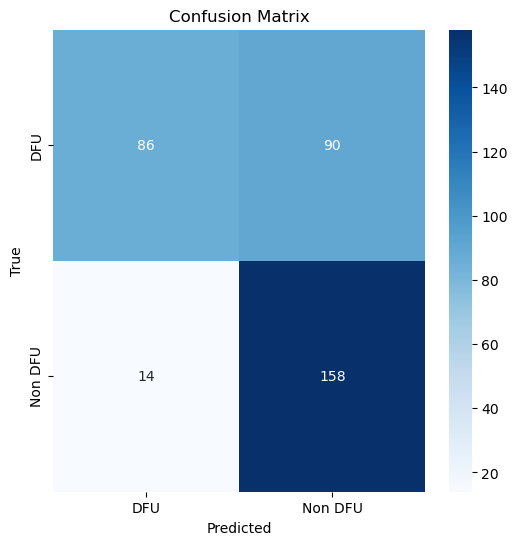

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7133479118347168     │
│          test_f1          │    0.5287290811538696     │
│         test_loss         │    0.6511952877044678     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6511952877044678,
  'test_acc': 0.7133479118347168,
  'test_f1': 0.5287290811538696}]

In [69]:
trainer = Trainer(
    max_epochs=100,
    accelerator="cpu",
    precision="32",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=True),
        ModelCheckpoint(monitor="val_f1", mode="max", save_top_k=1, dirpath="checkpoints/", filename="best-{epoch}-{val_f1:.2f}"),
        TQDMProgressBar(refresh_rate=1)
    ],
    logger=CSVLogger("logs", name="dfu_gcn"),
    log_every_n_steps=1,
)


pos_weight = 1.0  # Balanced dataset
model = DFUGCN(node_features=7, hidden_dim=128, pos_weight=pos_weight)
print("Starting training...")
trainer.fit(model, train_loader, val_loader)
print("Testing...")
trainer.test(model, test_loader)

Predicting the image

Loading best model from C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt...
Opening image: C:\Users\hp\Downloads\516.jpg
Image mode: RGB, size: (224, 224)
Tensor shape: torch.Size([3, 264, 264])
NumPy array shape: (264, 264, 3), dtype: float32
Segments shape: (264, 264), unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Number of regions: 25
Node features shape: (25, 7)
Edges shape: (112, 2)
Graph created for C:\Users\hp\Downloads\516.jpg: Data(x=[25, 7], edge_index=[2, 112], img_path='C:\Users\hp\Downloads\516.jpg')


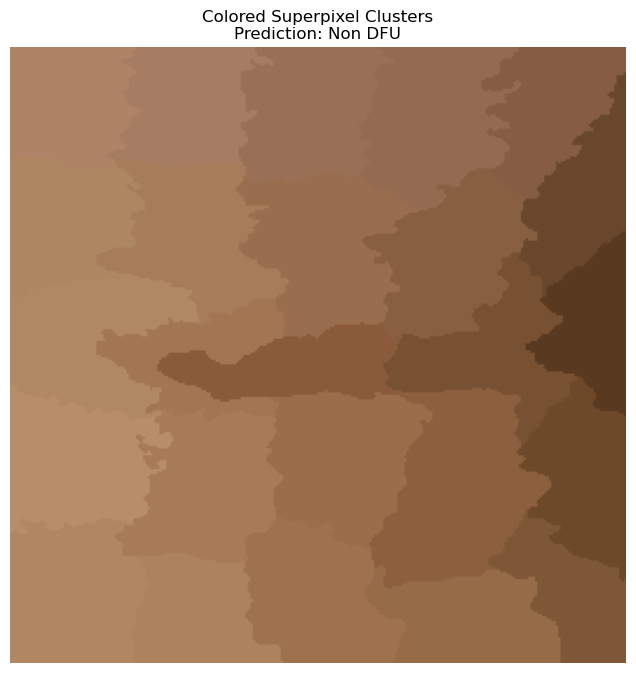

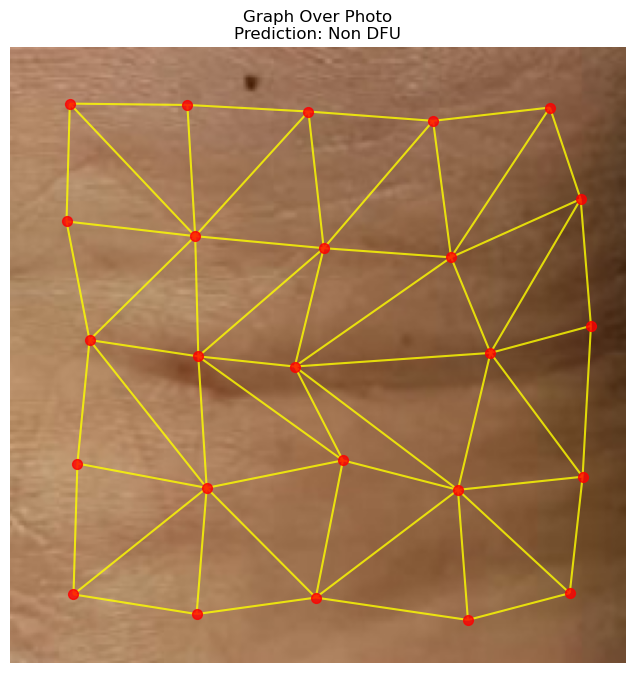

Image: C:\Users\hp\Downloads\516.jpg
Prediction: Non DFU


In [72]:
def predict_image(model, img_path, threshold=0.5, device='cpu', visualize=False):
    model.eval()
    model.to(device)
    
    graph = create_graph(img_path, label=None)
    if graph is None:
        return {"error": f"Failed to process {img_path}"}
    
    graph = graph.to(device)
    batch = Batch.from_data_list([graph])
    
    with torch.no_grad():
        logits = model(batch)
        prob = torch.sigmoid(logits).item()
        pred_label = "DFU" if prob < threshold else "Non DFU"  # Adjusted to match earlier logic
    
    if visualize:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img_tensor = slic_transform(img)
            img_np = img_tensor.permute(1, 2, 0).numpy()
            segments = slic(img_np, **SLIC_PARAMS)
            rag = skgraph.rag_mean_color(img_np, segments)
            props = regionprops(segments + 1)
            prop_dict = {p.label - 1: p for p in props}
            unique_seg_ids = np.unique(segments)
        
        clustered_img = np.zeros_like(img_np)
        for seg_id in unique_seg_ids:
            mask = segments == seg_id
            if np.any(mask):
                clustered_img[mask] = img_np[mask].mean(axis=0)
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Colored Superpixel Clusters\nPrediction: {pred_label}")
        plt.imshow(clustered_img)
        plt.axis('off')
        plt.show()
        
        G = nx.Graph()
        seg_id_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_seg_ids)}
        centroids = {seg_id: (prop.centroid[1], prop.centroid[0]) for seg_id, prop in prop_dict.items()}
        for seg_id in unique_seg_ids:
            if seg_id in seg_id_to_idx and seg_id in centroids:
                G.add_node(seg_id_to_idx[seg_id], pos=centroids[seg_id])
        for edge in rag.edges():
            u, v = edge[0], edge[1]
            if u in seg_id_to_idx and v in seg_id_to_idx:
                G.add_edge(seg_id_to_idx[u], seg_id_to_idx[v])
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Graph Over Photo\nPrediction: {pred_label}")
        plt.imshow(img_np)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_color='red', node_size=50, alpha=0.8)
        nx.draw_networkx_edges(G, pos, edge_color='yellow', width=1.5, alpha=0.8)
        plt.axis('off')
        plt.show()
    
    return {
        "image_path": img_path,
        "prediction": pred_label,
        "probability": prob
    }

# 6. Run Prediction
best_model_path = r"C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt"
print(f"Loading best model from {best_model_path}...")
model = DFUGCN.load_from_checkpoint(best_model_path, pos_weight=0.6)
test_image_path = r"C:\Users\hp\Downloads\516.jpg"
result = predict_image(model, test_image_path, threshold=0.5, device='cpu', visualize=True)
if "error" in result:
    print(result["error"])
else:
    print(f"Image: {result['image_path']}")
    print(f"Prediction: {result['prediction']}")
    

Loading best model from C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt...
Opening image: D:\Academics\ML_Proj\DFU\EXTRA\155.jpg
Image mode: RGB, size: (224, 224)
Tensor shape: torch.Size([3, 264, 264])
NumPy array shape: (264, 264, 3), dtype: float32
Segments shape: (264, 264), unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Number of regions: 22
Node features shape: (22, 7)
Edges shape: (94, 2)
Graph created for D:\Academics\ML_Proj\DFU\EXTRA\155.jpg: Data(x=[22, 7], edge_index=[2, 94], img_path='D:\Academics\ML_Proj\DFU\EXTRA\155.jpg')


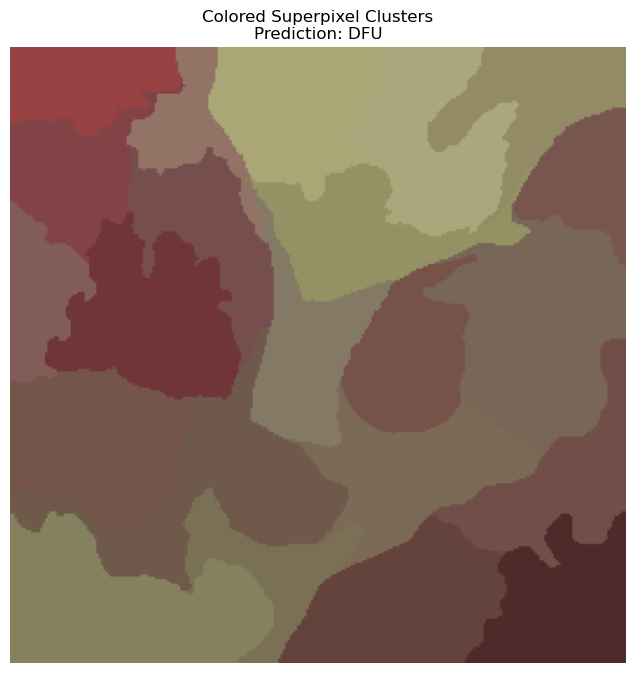

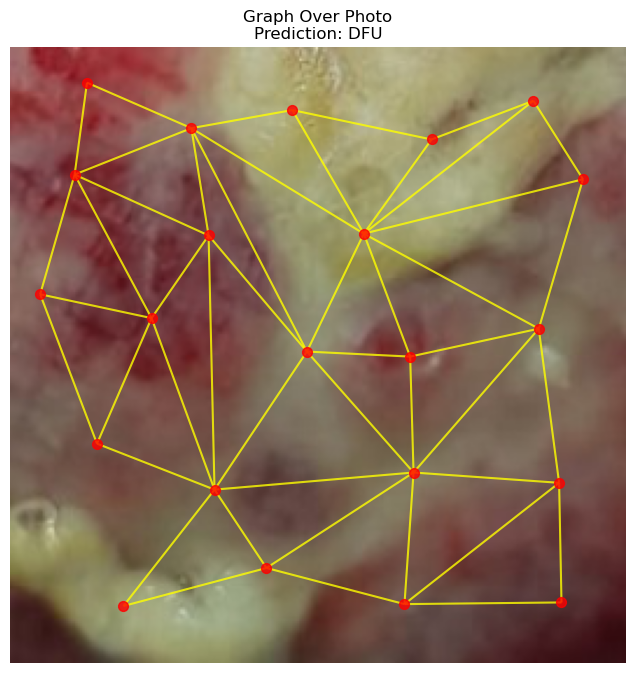

Image: D:\Academics\ML_Proj\DFU\EXTRA\155.jpg
Prediction: DFU


In [74]:
def predict_image(model, img_path, threshold=0.5, device='cpu', visualize=False):
    model.eval()
    model.to(device)
    
    graph = create_graph(img_path, label=None)
    if graph is None:
        return {"error": f"Failed to process {img_path}"}
    
    graph = graph.to(device)
    batch = Batch.from_data_list([graph])
    
    with torch.no_grad():
        logits = model(batch)
        prob = torch.sigmoid(logits).item()
        pred_label = "DFU" if prob < threshold else "Non DFU"  # Adjusted to match earlier logic
    
    if visualize:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img_tensor = slic_transform(img)
            img_np = img_tensor.permute(1, 2, 0).numpy()
            segments = slic(img_np, **SLIC_PARAMS)
            rag = skgraph.rag_mean_color(img_np, segments)
            props = regionprops(segments + 1)
            prop_dict = {p.label - 1: p for p in props}
            unique_seg_ids = np.unique(segments)
        
        clustered_img = np.zeros_like(img_np)
        for seg_id in unique_seg_ids:
            mask = segments == seg_id
            if np.any(mask):
                clustered_img[mask] = img_np[mask].mean(axis=0)
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Colored Superpixel Clusters\nPrediction: {pred_label}")
        plt.imshow(clustered_img)
        plt.axis('off')
        plt.show()
        
        G = nx.Graph()
        seg_id_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_seg_ids)}
        centroids = {seg_id: (prop.centroid[1], prop.centroid[0]) for seg_id, prop in prop_dict.items()}
        for seg_id in unique_seg_ids:
            if seg_id in seg_id_to_idx and seg_id in centroids:
                G.add_node(seg_id_to_idx[seg_id], pos=centroids[seg_id])
        for edge in rag.edges():
            u, v = edge[0], edge[1]
            if u in seg_id_to_idx and v in seg_id_to_idx:
                G.add_edge(seg_id_to_idx[u], seg_id_to_idx[v])
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Graph Over Photo\nPrediction: {pred_label}")
        plt.imshow(img_np)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_color='red', node_size=50, alpha=0.8)
        nx.draw_networkx_edges(G, pos, edge_color='yellow', width=1.5, alpha=0.8)
        plt.axis('off')
        plt.show()
    
    return {
        "image_path": img_path,
        "prediction": pred_label,
        "probability": prob
    }

# 6. Run Prediction
best_model_path = r"C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt"
print(f"Loading best model from {best_model_path}...")
model = DFUGCN.load_from_checkpoint(best_model_path, pos_weight=0.6)
test_image_path = r"D:\Academics\ML_Proj\DFU\EXTRA\155.jpg"
result = predict_image(model, test_image_path, threshold=0.5, device='cpu', visualize=True)
if "error" in result:
    print(result["error"])
else:
    print(f"Image: {result['image_path']}")
    print(f"Prediction: {result['prediction']}")
    

Loading best model from C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt...
Opening image: D:\Academics\ML_Proj\DFU\EXTRA\138.jpg
Image mode: RGB, size: (224, 224)
Tensor shape: torch.Size([3, 264, 264])
NumPy array shape: (264, 264, 3), dtype: float32
Segments shape: (264, 264), unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Number of regions: 21
Node features shape: (21, 7)
Edges shape: (86, 2)
Graph created for D:\Academics\ML_Proj\DFU\EXTRA\138.jpg: Data(x=[21, 7], edge_index=[2, 86], img_path='D:\Academics\ML_Proj\DFU\EXTRA\138.jpg')


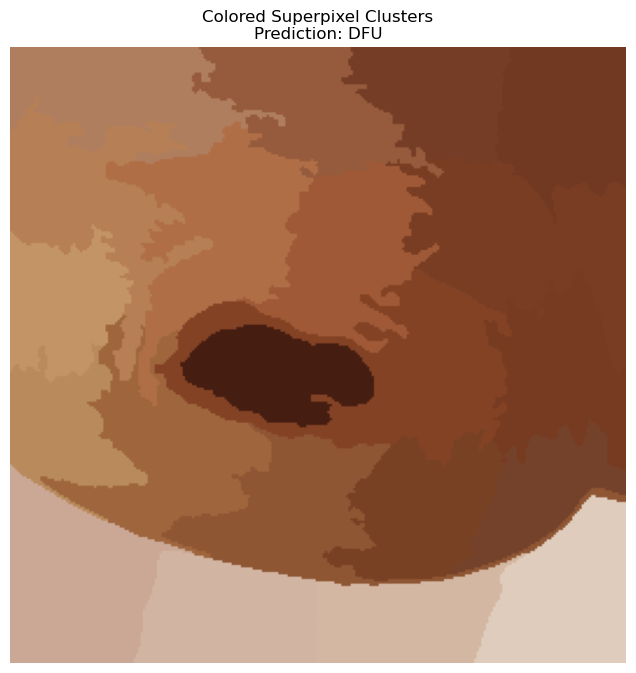

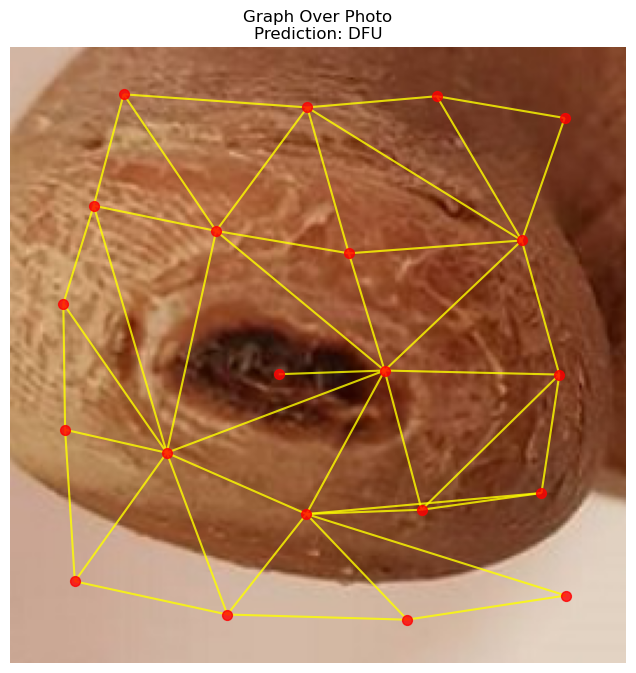

Image: D:\Academics\ML_Proj\DFU\EXTRA\138.jpg
Prediction: DFU


In [76]:
def predict_image(model, img_path, threshold=0.5, device='cpu', visualize=False):
    model.eval()
    model.to(device)
    
    graph = create_graph(img_path, label=None)
    if graph is None:
        return {"error": f"Failed to process {img_path}"}
    
    graph = graph.to(device)
    batch = Batch.from_data_list([graph])
    
    with torch.no_grad():
        logits = model(batch)
        prob = torch.sigmoid(logits).item()
        pred_label = "DFU" if prob < threshold else "Non DFU"  # Adjusted to match earlier logic
    
    if visualize:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img_tensor = slic_transform(img)
            img_np = img_tensor.permute(1, 2, 0).numpy()
            segments = slic(img_np, **SLIC_PARAMS)
            rag = skgraph.rag_mean_color(img_np, segments)
            props = regionprops(segments + 1)
            prop_dict = {p.label - 1: p for p in props}
            unique_seg_ids = np.unique(segments)
        
        clustered_img = np.zeros_like(img_np)
        for seg_id in unique_seg_ids:
            mask = segments == seg_id
            if np.any(mask):
                clustered_img[mask] = img_np[mask].mean(axis=0)
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Colored Superpixel Clusters\nPrediction: {pred_label}")
        plt.imshow(clustered_img)
        plt.axis('off')
        plt.show()
        
        G = nx.Graph()
        seg_id_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_seg_ids)}
        centroids = {seg_id: (prop.centroid[1], prop.centroid[0]) for seg_id, prop in prop_dict.items()}
        for seg_id in unique_seg_ids:
            if seg_id in seg_id_to_idx and seg_id in centroids:
                G.add_node(seg_id_to_idx[seg_id], pos=centroids[seg_id])
        for edge in rag.edges():
            u, v = edge[0], edge[1]
            if u in seg_id_to_idx and v in seg_id_to_idx:
                G.add_edge(seg_id_to_idx[u], seg_id_to_idx[v])
        
        plt.figure(figsize=(8, 8))
        plt.title(f"Graph Over Photo\nPrediction: {pred_label}")
        plt.imshow(img_np)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_color='red', node_size=50, alpha=0.8)
        nx.draw_networkx_edges(G, pos, edge_color='yellow', width=1.5, alpha=0.8)
        plt.axis('off')
        plt.show()
    
    return {
        "image_path": img_path,
        "prediction": pred_label,
        "probability": prob
    }

# 6. Run Prediction
best_model_path = r"C:\Users\hp\checkpoints\best-epoch=11-val_acc=0.73.ckpt"
print(f"Loading best model from {best_model_path}...")
model = DFUGCN.load_from_checkpoint(best_model_path, pos_weight=0.6)
test_image_path = r"D:\Academics\ML_Proj\DFU\EXTRA\138.jpg"
result = predict_image(model, test_image_path, threshold=0.5, device='cpu', visualize=True)
if "error" in result:
    print(result["error"])
else:
    print(f"Image: {result['image_path']}")
    print(f"Prediction: {result['prediction']}")
    